In [1]:
import pandas as pd
app_df = pd.read_csv("/kaggle/input/credit-card-approval-prediction/application_record.csv")
credit_df = pd.read_csv("/kaggle/input/credit-card-approval-prediction/credit_record.csv")
print(app_df.head())
print(app_df.info())
print(app_df.isnull().sum())
merged_df = pd.merge(app_df, credit_df, on='ID', how='inner')
print(merged_df.head())
print(credit_df['STATUS'].value_counts())


        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005 

In [2]:
bad_statuses = ['1', '2', '3', '4', '5']
target_df = credit_df.groupby('ID')['STATUS'].apply(lambda x: 0 if any(status in bad_statuses for status in x) else 1).reset_index()
target_df.columns = ['ID', 'TARGET']
print(target_df.head())

        ID  TARGET
0  5001711       1
1  5001712       1
2  5001713       1
3  5001714       1
4  5001715       1


In [3]:
final_df = pd.merge(app_df, target_df, on='ID' ,how='inner')
print(final_df.head())
print(final_df['TARGET'].value_counts())

        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005 

In [6]:
from sklearn.preprocessing import StandardScaler
print(final_df.isnull().sum())
final_df['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)
categorical_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                    'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']

df_encoded = pd.get_dummies(final_df, columns=categorical_cols)


scaler = StandardScaler()

numeric_cols = ['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']

df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])
# Drop ID column
df_encoded.drop('ID', axis=1, inplace=True)

# Separate features (X) and label (y)
X = df_encoded.drop('TARGET', axis=1)
y = df_encoded['TARGET']


ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
TARGET                 0
dtype: int64


In [8]:
import pandas as pd

categorical_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                    'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']

df_encoded = pd.get_dummies(final_df, columns=categorical_cols)


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_cols = ['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']

df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])


In [10]:
X = df_encoded.drop(['ID', 'TARGET'], axis=1)
y = df_encoded['TARGET']


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[ 275  597]
 [ 217 6203]]

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.32      0.40       872
           1       0.91      0.97      0.94      6420

    accuracy                           0.89      7292
   macro avg       0.74      0.64      0.67      7292
weighted avg       0.87      0.89      0.87      7292



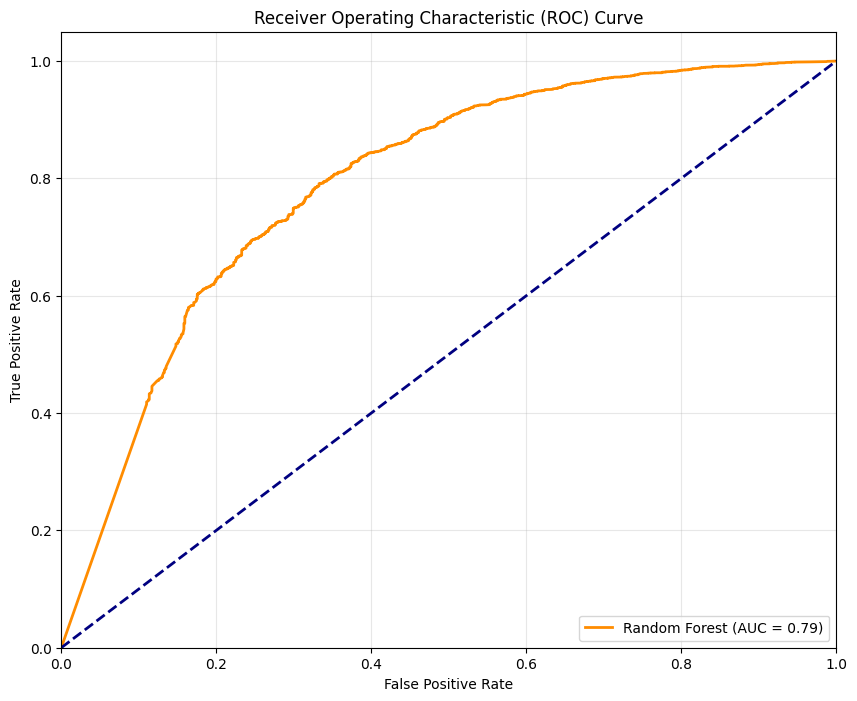

ROC AUC Score: 0.7920


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Get prediction probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Print AUC score
print(f'ROC AUC Score: {roc_auc:.4f}')